# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 20.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=388447459dca2cd513a8228443d71a50f0156a6ec962de67618c97c35bb5f4cb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=ba55f18dc1c482dda3d2a0ec6ea01299f011b16824e8282bd6b5f9a7ad819c7a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c601

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 11.89 MiB/s, done.
Resolving deltas: 100% (3/3), done.


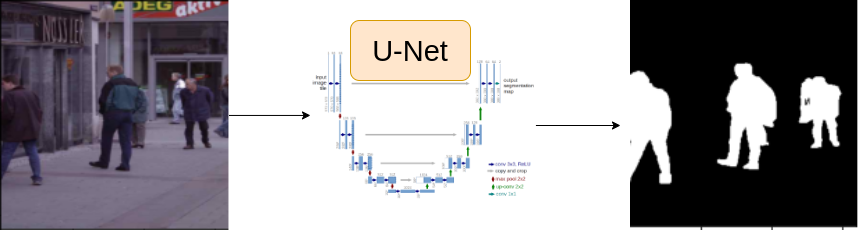

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE = 'cuda'

EPOCHS = 100
BATCH_SIZE = 16
IMAGE_SIZE = 320
LEARNING_RATE = 0.003

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.loc[4]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

print(f"Image Shape : {image.shape}")
print(f"Mask Shape : {mask.shape}")

Image Shape : (408, 612, 3)
Mask Shape : (408, 612)


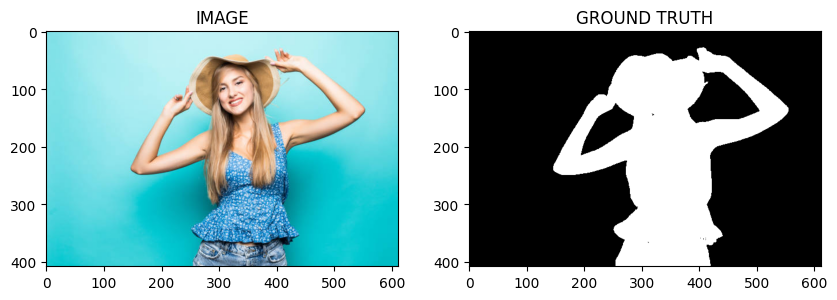

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
from albumentations import Compose, OneOf, HorizontalFlip, VerticalFlip, Rotate

def get_train_augs():
    return Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Rotate(limit=45, p=0.5),
        # Try removing or adjusting the RandomCrop operation
        # RandomCrop(height=256, width=256, p=0.5),
    ])

def get_valid_augs():
    return Compose([
        # No augmentations for validation
    ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import torch

class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Ensure the mask has the same dimensions as the image
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    mask = np.expand_dims(mask, axis=-1)
    if self.augmentations:
      aug = self.augmentations(image=image, mask=mask)
      image = aug['image']
      mask = aug['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)
    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


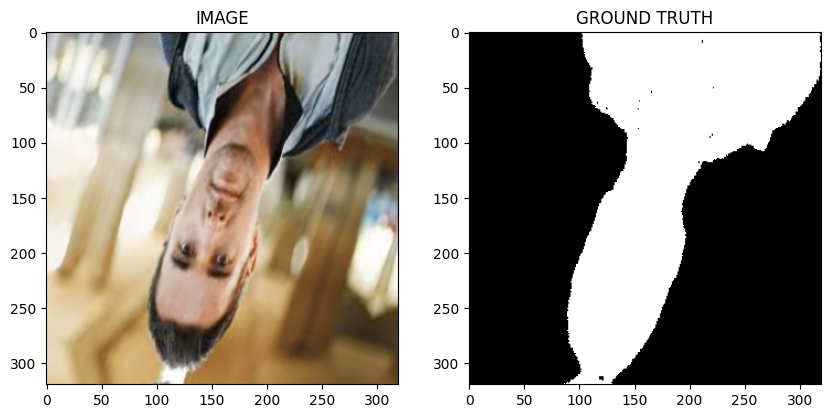

In [ ]:
idx = 32
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader : {len(trainloader)}") #232/16~15, 232 is the length, and 16 is the given batch_size
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [ ]:
for image,mask in trainloader:
  print(f"Image batch shape : {image.shape}")
  print(f"Mask batch shape : {mask.shape}")
  break

Image batch shape : torch.Size([16, 3, 320, 320])
Mask batch shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

    self.loss_fn = DiceLoss(mode='binary')

  def forward(self, images, masks):
        logits = self.arc(images)
        if masks != None:
            loss1 = self.loss_fn(logits, masks)
            loss2 = torch.nn.BCEWithLogitsLoss()(logits, masks) # Use torch.nn directly
            loss = loss1 + loss2
            return logits, loss
        return logits



In [ ]:
model = SegmentationModel().to(DEVICE)

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss/len(data_loader) #avg loss

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
  return total_loss/len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
best_valid_loss = np.inf
for epoch in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)
  print(f"Epoch : {epoch+1}")
  print(f"Train Loss : {train_loss:.4f}")
  print(f"Valid Loss : {valid_loss:.4f}")
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pth')
    print('Saved Best Model!')

100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch : 1
Train Loss : 0.1893
Valid Loss : 0.2322
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 2
Train Loss : 0.1715
Valid Loss : 0.1937
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch : 3
Train Loss : 0.1490
Valid Loss : 0.2594


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch : 4
Train Loss : 0.1497
Valid Loss : 0.2017


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch : 5
Train Loss : 0.1284
Valid Loss : 0.2285


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Epoch : 6
Train Loss : 0.1596
Valid Loss : 0.1911
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


Epoch : 7
Train Loss : 0.1696
Valid Loss : 0.2269


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 8
Train Loss : 0.1327
Valid Loss : 0.1943


100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch : 9
Train Loss : 0.1306
Valid Loss : 0.1824
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch : 10
Train Loss : 0.1200
Valid Loss : 0.1828


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch : 11
Train Loss : 0.1353
Valid Loss : 0.2569


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch : 12
Train Loss : 0.1122
Valid Loss : 0.2064


100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Epoch : 13
Train Loss : 0.1058
Valid Loss : 0.1745
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch : 14
Train Loss : 0.1050
Valid Loss : 0.1987


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Epoch : 15
Train Loss : 0.1178
Valid Loss : 0.2186


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch : 16
Train Loss : 0.1033
Valid Loss : 0.1818


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch : 17
Train Loss : 0.1066
Valid Loss : 0.1777


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 18
Train Loss : 0.1083
Valid Loss : 0.2160


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 19
Train Loss : 0.1227
Valid Loss : 0.1709
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch : 20
Train Loss : 0.1302
Valid Loss : 0.3180


 20%|██        | 3/15 [00:01<00:05,  2.37it/s]

# Task 9 : Inference

<ipython-input-57-114a62685c7f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))


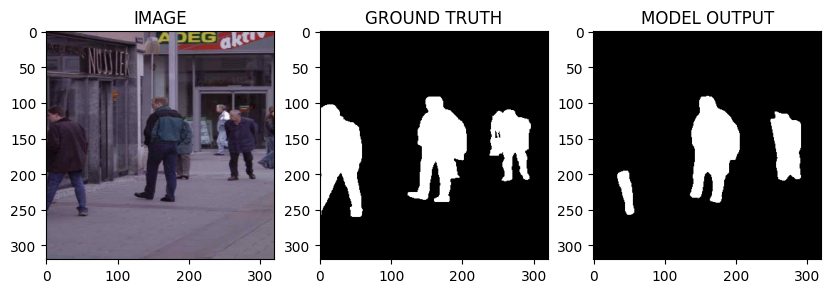

In [ ]:
idx = np.random.randint(0, len(validset))
idx = 20
image, mask = validset[idx]

model.load_state_dict(torch.load('/content/best_model.pth'))

logits_mask = model(image.to(DEVICE).unsqueeze(0), masks=None) # Add masks=None as an argument.
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0
pred_mask = pred_mask.detach().cpu().squeeze(0)

helper.show_image(image, mask, pred_mask)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya